Ce notebook se concentre sur la détection d'outliners :

On doit différencier la novelty detection (on a une représentation clean des datas) et la detection d'outliner (dans nos data d'entrainement, on a des outliner). Dans le cas de la novelty detection, on utilise un svm oneclass. 

plusieurs méthodes sont possibles voir https://scikit-learn.org/stable/modules/outlier_detection.html#outlier-detection

1. isolation forest : based on random forest. Efficient on high dimension
2. localOutlinerFactor : moderately high dimension, based on density
2. one class svm : sensitive to outliner. can be usefull in high dimension with finetuning of nu parameters
3. Elliptic envelop : assume data is gaussian and learn an elipse




In [ ]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import xarray as xr
from scipy import ndimage

In [4]:

import utils
data=utils.load_data_set()

In [8]:
def get_image(data,argument):
    if len(argument)==1:


        shape=(len(data.y.unique()),len(data.x.unique()))
        return np.array(data[argument]).reshape(shape)
    elif len(argument)==3:#image couleur
        shape=(len(data.y.unique()),len(data.x.unique()),3)
        return np.array(data[argument]).reshape(shape)

    

In [6]:
data.index.unique(level=0)

Index(['2018-06-07', '2019-05-03', '2019-04-18', '2019-05-18', '2019-05-28',
       '2019-06-07'],
      dtype='object', name='n')

Isolation forest : we have an abnomality score (based on average path lenght used to classify a data)

We have no parameter to fine tune
On est plus robuste aux grandes variations de la plage que pour les autres algorithmes

2018-06-07
2019-05-03
2019-04-18
2019-05-18
2019-05-28
2019-06-07


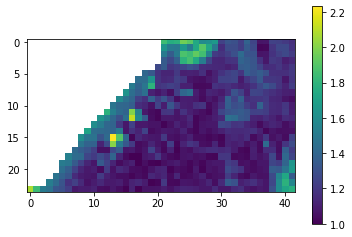

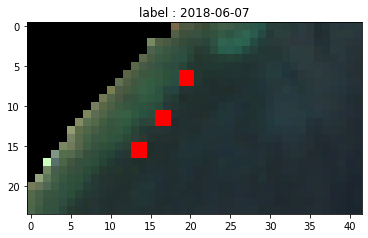

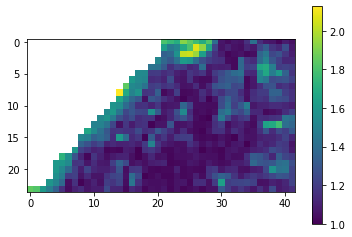

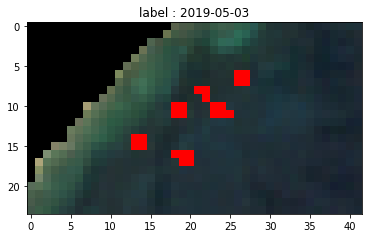

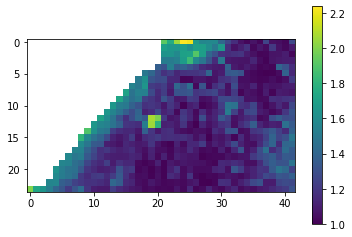

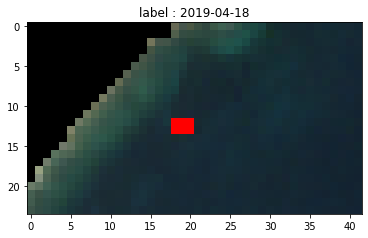

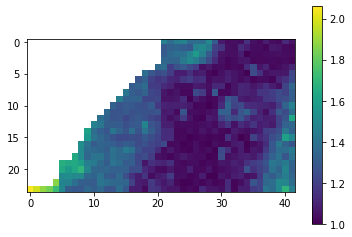

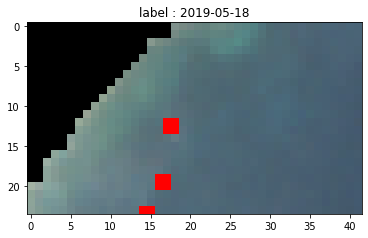

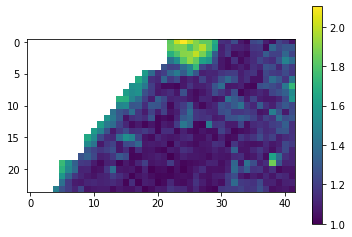

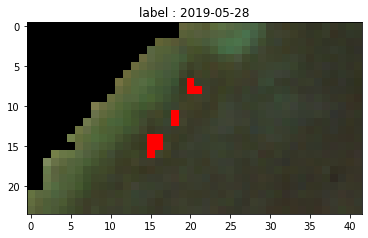

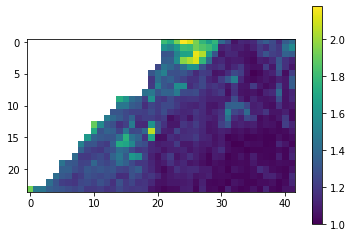

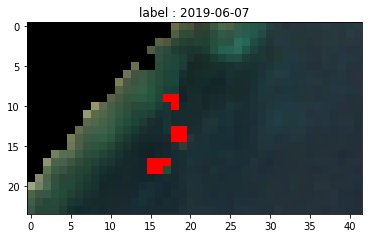

In [30]:
from sklearn.ensemble import IsolationForest

bands=['B04','B03','B02']
max_data=data[bands].max().max()

for i in data.index.unique(level=0):

    print(i)

    image=data.loc[i]

    target=image[["B02","B03","B04"]][image.distance>=4].dropna()
    clf = IsolationForest(random_state=0).fit(target)
    resultat=clf.score_samples(target)
    data.loc[i,"prediction"]=np.array(pd.Series(resultat,index=target.index).reindex(image.index))
    
    plt.figure()
    to_plot=get_image(data.loc[i],["prediction"])
    plt.imshow(to_plot/np.nanmax(to_plot))
    
    plt.colorbar()
    plt.figure()
    plt.title("label : "+i)
    to_plot=get_image(data.loc[i],bands)
    plt.imshow(to_plot/max_data)
    to_plot=get_image(data.loc[i],["label"])

    alphas=1*to_plot[:,:]
    plt.imshow(to_plot,alpha=alphas,cmap='rainbow')
    



Local outliner factor : 
we must tuned the 

-factor 1 : proportion of outliner. our proportion is small (<10%)

-factor 2 : dimension of the data: must be small enough

on a du mal a ajuster les facteurs (variabilité du dataset ?). On a beaucoup plus faux positif que dans le 1, mais plus intéressant

2018-06-07
2019-05-03
2019-04-18
2019-05-18
2019-05-28
2019-06-07


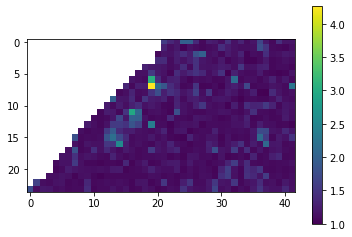

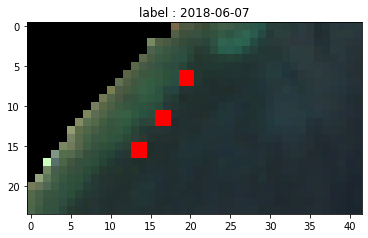

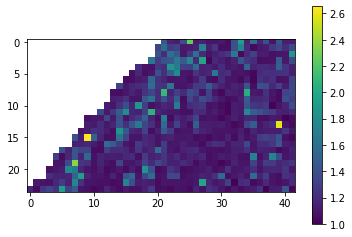

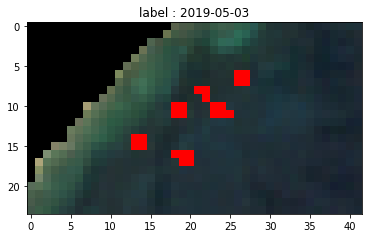

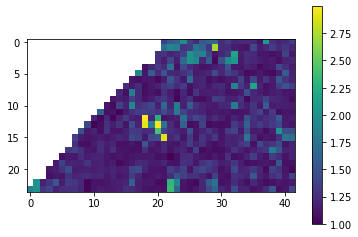

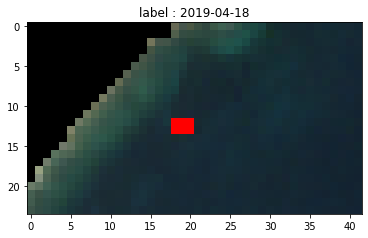

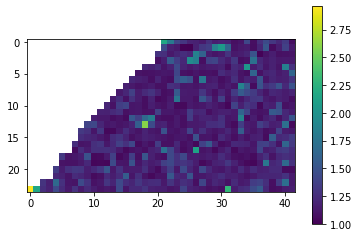

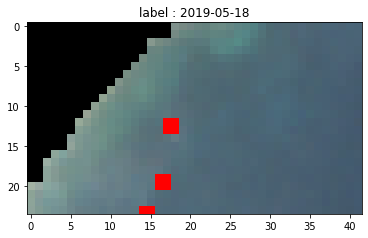

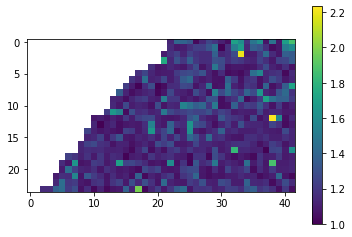

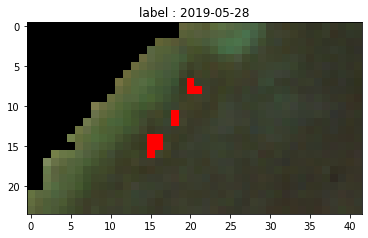

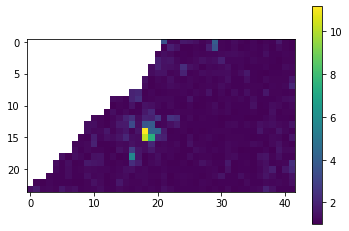

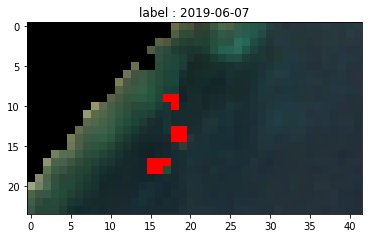

In [29]:
from sklearn.neighbors import LocalOutlierFactor

bands=['B04','B03','B02']
max_data=data[bands].max().max()

for i in data.index.unique(level=0):

    print(i)

    image=data.loc[i]
    plt.figure()
    target=image[["B04","B06","B08","B11"]][image.distance>3].dropna()
    clf = LocalOutlierFactor(n_neighbors=5)
    clf.fit_predict(target)
    resultat=clf.negative_outlier_factor_
    data.loc[i,"prediction"]=np.array(pd.Series(resultat,index=target.index).reindex(image.index))
    to_plot=get_image(data.loc[i],["prediction"])
    plt.imshow(to_plot/np.nanmax(to_plot))
    
    plt.colorbar()
    plt.figure()
    plt.title("label : "+i)
    to_plot=get_image(data.loc[i],bands)
    plt.imshow(to_plot/max_data)
    to_plot=get_image(data.loc[i],["label"])

    alphas=1*to_plot[:,:]
    plt.imshow(to_plot,alpha=alphas,cmap='rainbow')
    


svm oneclass:

On remarque que si jamais on a autre chose de plus variable (par exemple la cote), cela ne marche pas
Dans le cas contraire, on arrive a avoir des resultats
on doit spécifier le parametre nu et le kernel.

2018-06-07
2019-05-03
2019-04-18
2019-05-18
2019-05-28
2019-06-07


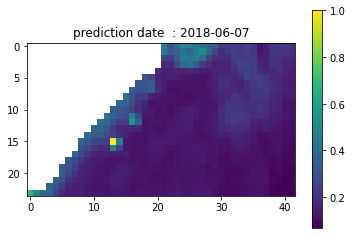

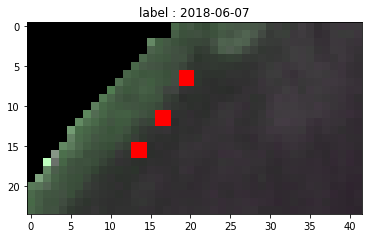

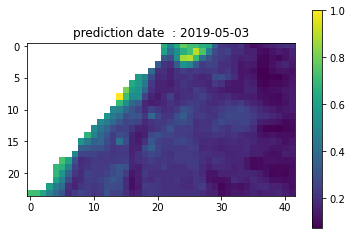

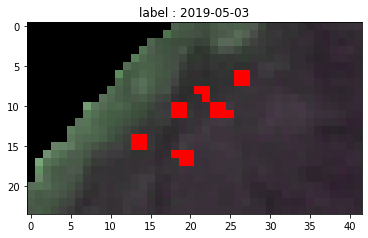

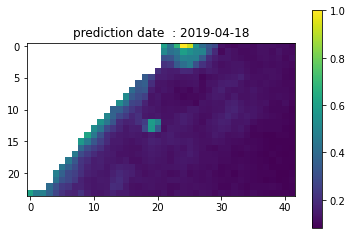

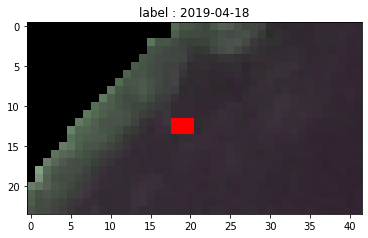

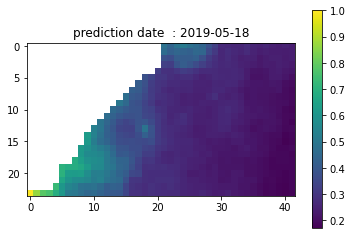

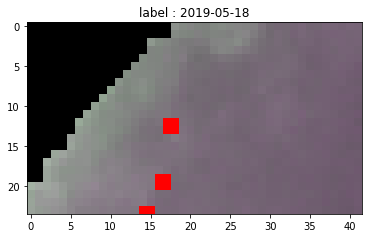

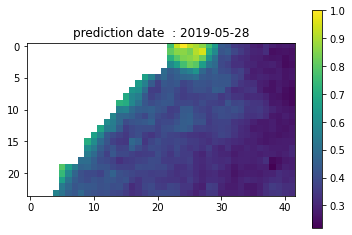

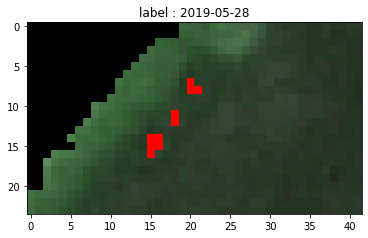

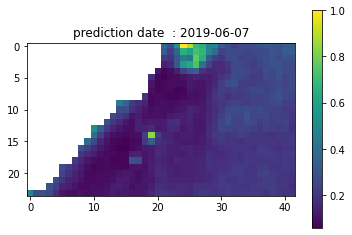

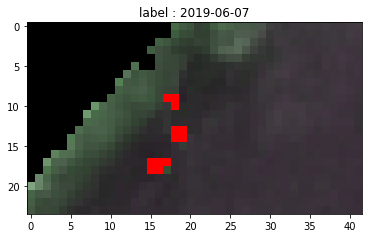

In [28]:
from sklearn.svm import OneClassSVM

bands=['B02','B03','B02']
max_data=data[bands].max().max()

for i in data.index.unique(level=0):

    print(i)

    image=data.loc[i]
    plt.figure()
    
    target=image[["B02","B03","B04","B06","B11"]][image.distance>=4].dropna()
    train=image[["B02","B03","B04","B06","B11"]][image.distance>=4].dropna()
   
    clf = OneClassSVM(gamma='auto',kernel='poly').fit(train)
    resultat=clf.predict(target)
    resultat=clf.score_samples(target)
    plt.title("prediction date  : "+i)
    data.loc[i,"prediction"]=np.array(pd.Series(resultat,index=target.index).reindex(image.index))
    

    to_plot=get_image(data.loc[i],["prediction"])
    plt.imshow(to_plot/np.nanmax(to_plot))
    
    plt.colorbar()
    plt.figure()
    plt.title("label : "+i)
    to_plot=get_image(data.loc[i],bands)
    plt.imshow(to_plot/max_data)
    to_plot=get_image(data.loc[i],["label"])

    alphas=1*to_plot[:,:]
    plt.imshow(to_plot,alpha=alphas,cmap='rainbow')
    
    